# 04wk-016: 타이타닉 / 결측치처리+로지스틱 – 추가해설

최규빈  
2023-09-26

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-z8ceMijNQrcczhH3ocuP1Y&si=UehL2BELwmid586_>

# 2. imports

In [1]:
import numpy as np 
import pandas as pd 
import sklearn.impute
import sklearn.linear_model
import missingno as msno

# 3. 자료불러오기

`-` 아래의 코드는 `kaggle.json` 파일이 셋팅된 codespace 혹은
`kaggle.json` 파일이 셋팅된 리눅스 컴퓨터가 있는 경우만 사용가능 (이런거
셋팅하는 방법은 대면수업에서..)

In [2]:
!kaggle competitions download -c titanic
!unzip titanic.zip -d ./titanic
df_train = pd.read_csv('titanic/train.csv')
df_test = pd.read_csv('titanic/test.csv')
!rm titanic.zip
!rm -rf titanic/

  0%|                                               | 0.00/34.1k [00:00<?, ?B/s]
100%|███████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 408kB/s]
Archive:  titanic.zip
  inflating: ./titanic/gender_submission.csv  
  inflating: ./titanic/test.csv      
  inflating: ./titanic/train.csv     

`-` 리눅스서버를 사용할 수 없는 경우 download 후 압축풀어서 사용

# 4. 결측치 확인 및 처리

## A. 결측치 체크

`-` 결측치확인

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

## B. 시각화

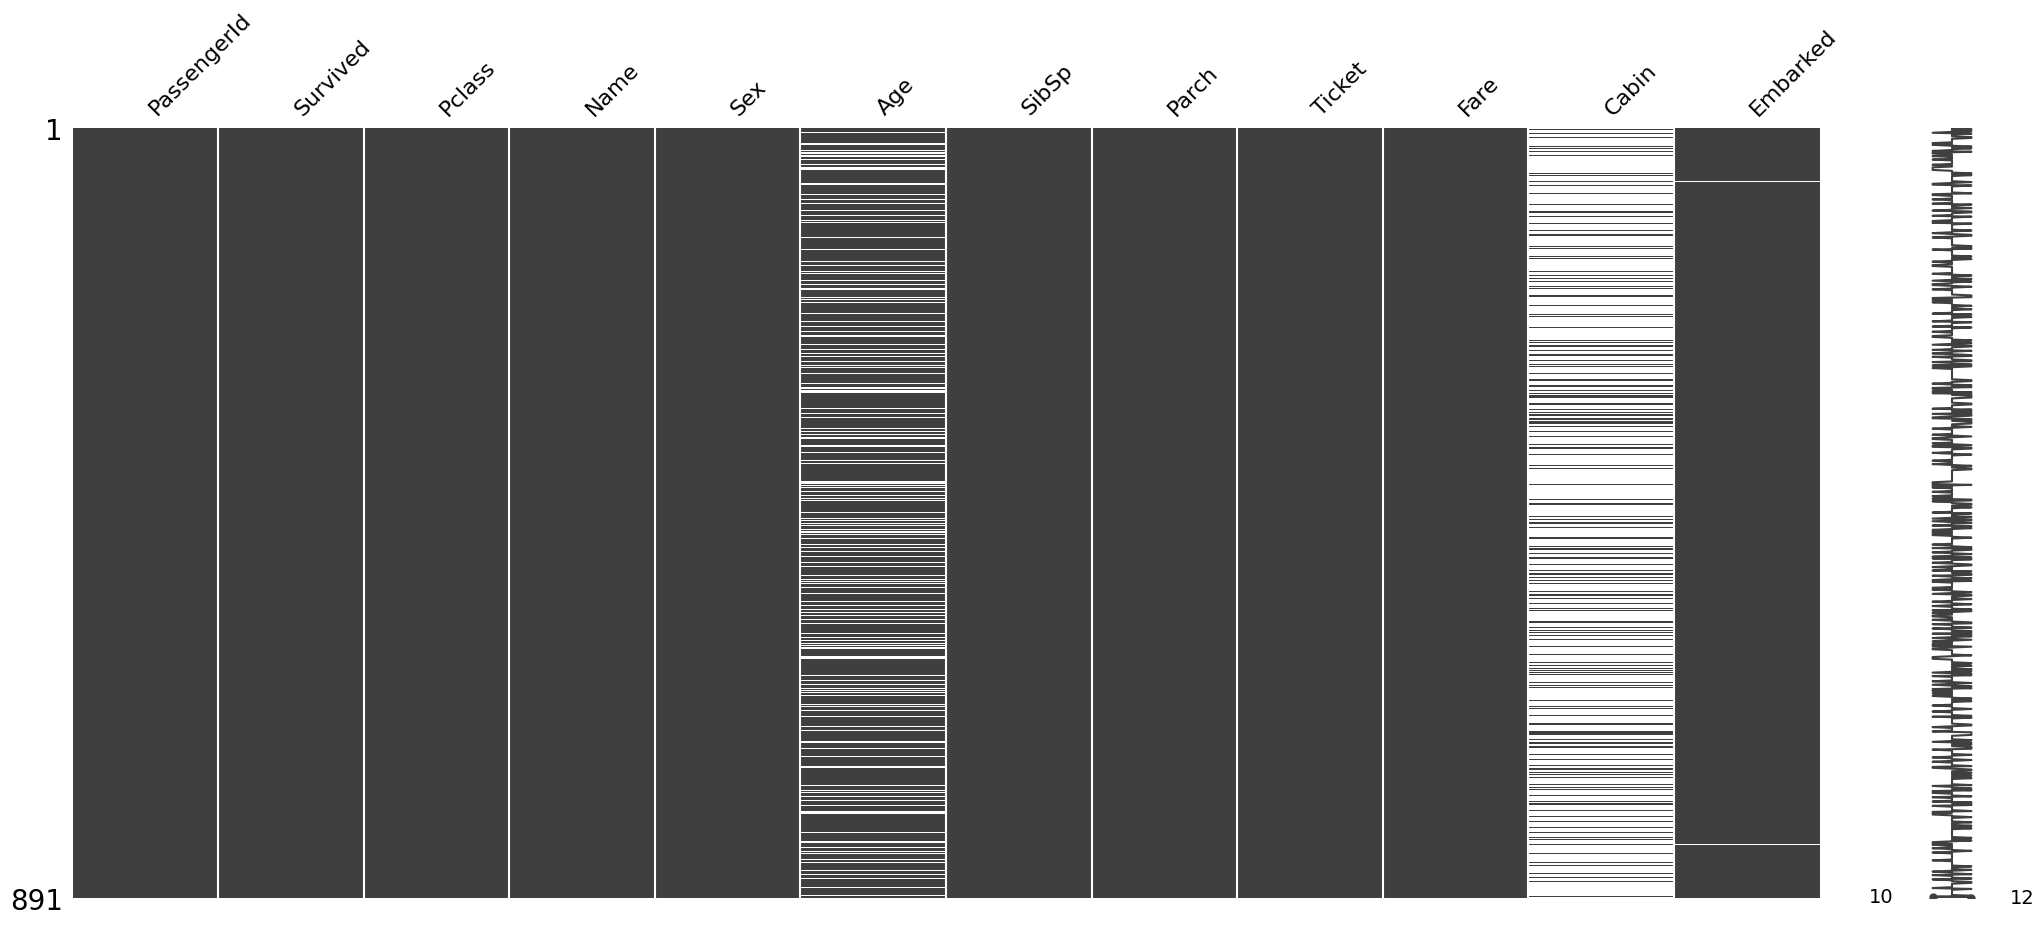

In [4]:
msno.matrix(df_train) 
# msno.bar(df_train) # 큰 의미 X 
# msno.dendrogram(df_train) # 큰 의미 X 
# msno.heatmap(df_train) # 큰 의미 X 

## C. 결측치 처리

In [5]:
df_train.select_dtypes(include="number")

In [6]:
def impute_missing(df):
    df_imputed = df.copy()
    df_num = df.select_dtypes(include="number")
    df_cat = df.select_dtypes(exclude="number")
    df_imputed[df_num.columns] = sklearn.impute.SimpleImputer().fit_transform(df_num) 
    df_imputed[df_cat.columns] = sklearn.impute.SimpleImputer(strategy='most_frequent').fit_transform(df_cat) 
    return df_imputed

In [7]:
impute_missing(df_test)

> **2023-10-24 추가해설**
>
> **결측치 처리가 별로임**: 사실 타이타닉 자료의 경우 위와 같이
> train/test를 독립된 데이터세트로 보고 결측치를 처리하는 것 보다
> `모듈19-MinMaxScaler`에서 소개한 것 처럼 train에서 fit한 `imputer`를
> test에서 `.transform()`하는 것이 훨씬 자연스럽다. 다만 이 예제를
> 설명하는 단계에서는 train/test를 독립된 데이터세트로 보고 전처리를 할
> 경우 생기는 비상식을 이해하기 어려워 위와 같은 방식으로 진행했음.

# 5. 분석

## A. 자료의 정리

In [8]:
{c:len(set(df_train[c])) for c in df_train.select_dtypes(include="object").columns}

In [9]:
X = pd.get_dummies(impute_missing(df_train).drop(['Survived','Name','Ticket','Cabin'],axis=1))
y = impute_missing(df_train)[['Survived']]

> **2023-10-24 추가해설**
>
> **너무 많은 범주**: Name, Ticket, Cabin은 너무 많은 범주를 포함하고
> 있으므로 제외한다고 설명했다. 그런데 사실
>
> 1.  이름에는 혼인여부에 대한 정보가 포함될 수도 있어서 버리기 아깝다.
> 2.  범주가 너무 많다면 통째로 변수를 제거하는 것 보다, 공통범주로
>     묶어서 처리하는 방법도 고려할 수 있다.
>
> 는 점에서 다른 분석방법을 고려할 수도 있다.

> **2023-10-24 추가해설**
>
> **PassengerId**: 사실 `PassengerId`불필요한 정보이고 (`PassengerId` 와
> y는 corr이 없음) 있어봤자 오버핏만 유발하므로 제외하는게 좋다. 단지 이
> 시점에서는 “불필요한 변수를 제거하지 않으면 왜 오버피팅 현상이
> 발생하는가?” 를 설명할 수 없어서 남겨두었던 것.

## B. predictor 생성

In [10]:
predictr = sklearn.linear_model.LogisticRegression()

## C. 학습

In [11]:
predictr.fit(X,y)

/home/cgb2/anaconda3/envs/ag/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/cgb2/anaconda3/envs/ag/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

## D. 예측

In [12]:
predictr.predict(X)

## E. 평가

In [13]:
predictr.score(X,y)

# 6. HW

위와 동일한 방식으로 `test.csv`에서의 생존여부를 예측하고 kaggle에 제출

In [14]:
#!kaggle competitions submit -c titanic -f submission.csv -m "Message"